In [1]:
%matplotlib inline

import os
import tarfile
# from six.moves import urllib
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


# fetch_housing_data()
housing = load_housing_data()

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
#Note: total_bedrooms has missing data

#Note: ocean_proximity is not a numeric field, it's text
display(housing['ocean_proximity'].value_counts())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
#Now we know the entire set of categories involved

# Map text properties to numeric
ocean_prox, ocean_prox_idx = housing['ocean_proximity'].factorize()

ocean_prox_idx

Index(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], dtype='object')

In [5]:
display(housing['ocean_proximity'].head())
housing['ocean_proximity'] = ocean_prox
housing['ocean_proximity'].head()

0    NEAR BAY
1    NEAR BAY
2    NEAR BAY
3    NEAR BAY
4    NEAR BAY
Name: ocean_proximity, dtype: object

0    0
1    0
2    0
3    0
4    0
Name: ocean_proximity, dtype: int64

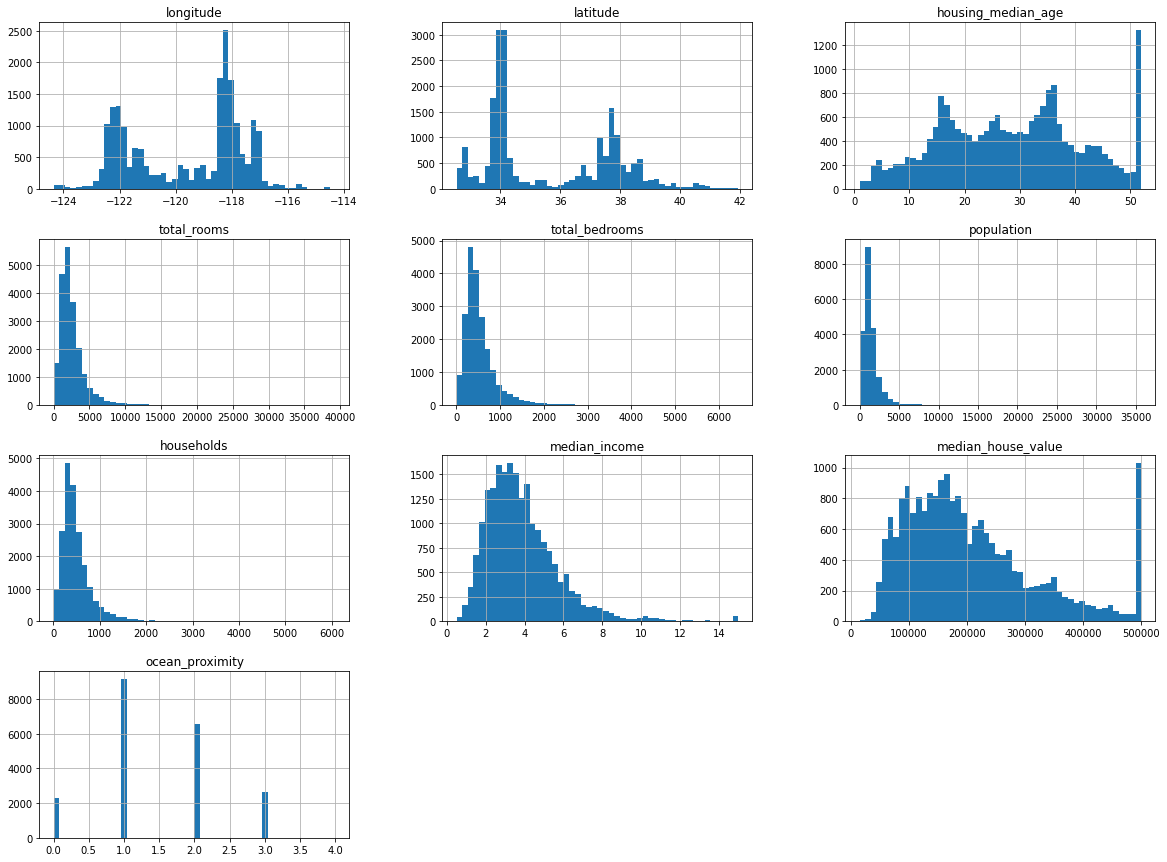

In [6]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
# Data Snoop Bias so take 20% of the data as test and 80% for training
# [ This code block for Learning MOSTLY (except: unique_id generation) ]

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[: test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


train_set, test_set = split_train_test(housing, 0.2)
print("Manual shuffle training set size N={}\n".format(len(train_set)))

# But what if you need to iteratively re-split the dataset consistently with the same random grouping?
# Then you need unique identifiers and a more advanced way to randomly split using the unique set of ids

from zlib import crc32 

def test_set_check(identifier, test_ratio): 
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~ in_test_set], data.loc[in_test_set]

# housing_with_id = housing.reset_index()  # adds an `index` column 
# train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

housing_with_id = housing
# *** Weakness in uniqueness in id: Data must always be appended if this becomes a interative pipeline!
housing_with_id["id"] = (housing["longitude"] * housing["latitude"]) + housing.index.values 
print('Is id formulation unique:', housing_with_id['id'].is_unique)

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

print("Training_by_id set size N={}\n".format(len(train_set)))

Manual shuffle training set size N=16512

Is id formulation unique: True
Training_by_id set size N=16516



In [8]:
# Data Snoop Bias so take 20% of the data as test and 80% for training
# [ This code block for Learning ONLY ]

# What if you have multiple dataframes that need to be split on the same identifier?
# then you need to go from "split_train_test" to "train_test_split"

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# Note: train set size falls back to the same as the manual shuffle
print("Training set size N={}".format(len(train_set)))

Training set size N=16512


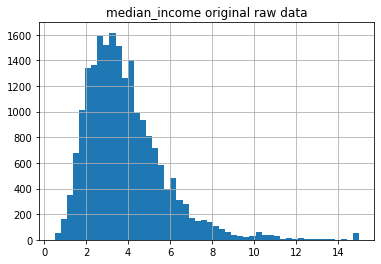


Describing Central Tendencies of:'median_income'

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64



In [9]:
# Setting up training sets is not always that straight forward.  Predicting housing prices seems to have a strong
# dependence on a buyers income, so median_income is likely important.
#
# Let's create an income category to cluster incomes into integer classes used to stratify the data 
# Note: we will need significant amounts within each group which we'll check-up on
#
# Visually between 1.5 to 5 we see most of the data and most of the data tails-off 8 and higher
# But the book says 2-5 cap 5 or 6.  Why? Because of the following...


housing['median_income'].hist(bins=50)
plt.title('median_income original raw data')
plt.show()
print("\nDescribing Central Tendencies of:'median_income'\n\n{}\n".format(housing['median_income'].describe()))

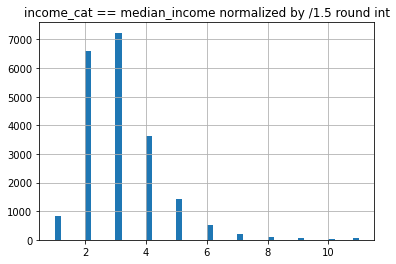

count    20640.000000
mean         3.093362
std          1.303707
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: income_cat, dtype: float64

In [10]:
# Visually we see the center of the distribution coincides with th 50%_percentile, but the numeric breakdown
# using he describe function shows the arithmatic mean ~4. 
# 
# To create a guiassian normal distrubtion for the income category we might do the following:
#
# Use the 50%_percentile ~3.5 and std ~2
# So (mean-sigma = 1.5) and (mean+sigma = 5.5) 
#
# dividing all values by 1.5 (as a normalization factor) means values below 1.5 are less than 1
# and values starting at 1.5 become a category value of 1, and >1 become fractions rounded-up to int values

housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].hist(bins=50)
plt.title('income_cat == median_income normalized by /1.5 round int')
plt.show()
housing['income_cat'].describe()

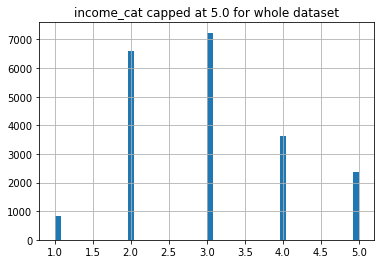


Value Counts from dataframe column:
3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64



In [11]:
housing['income_cat'].where(housing['income_cat']<5, other=5.0, inplace=True)
housing['income_cat'].hist(bins=50)
plt.title('income_cat capped at 5.0 for whole dataset')
plt.show()

# Plots are nice, print the values too
print("\nValue Counts from dataframe column:\n{}\n".format(housing['income_cat'].value_counts()))

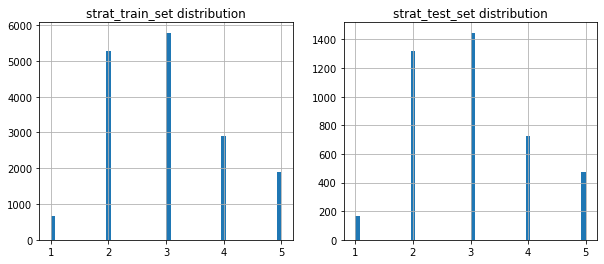

,%in_cat full,%in_cat train,%in_cat test
3.0,35.058140,35.059351,35.053295
2.0,31.884690,31.885901,31.879845
4.0,17.630814,17.629603,17.635659
5.0,11.443798,11.446221,11.434109
1.0,3.982558,3.978924,3.997093


In [12]:
# Data Snoop Bias so take 20% of the data as test and 80% for training
# This code block IS how we will randomly split the data into training and test constrained to the 'income_cat'
# distribution

from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in strat_split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Merge our hist % distributions into a new table
dist_pcts = pd.concat([housing['income_cat'].value_counts()/len(housing)*100,
                       strat_train_set['income_cat'].value_counts()/len(strat_train_set)*100, 
                       strat_test_set['income_cat'].value_counts()/len(strat_test_set)*100
                      ], axis=1)
dist_pcts.columns = ['%in_cat full', '%in_cat train', '%in_cat test']

# Use subplots to plot multiple charts side-by-side
fig, ax = plt.subplots(1,2, figsize=(10,4))
strat_train_set['income_cat'].hist(bins=50, ax=ax[0]).set_title('strat_train_set distribution')
strat_test_set['income_cat'].hist(bins=50, ax=ax[1]).set_title('strat_test_set distribution')

plt.show()
display(dist_pcts)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

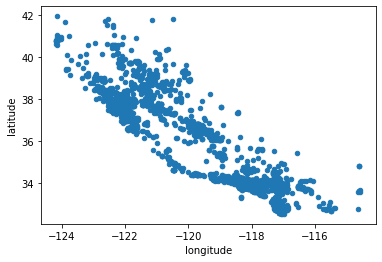

In [13]:
strat_test_set.plot(kind='scatter', x='longitude', y='latitude')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

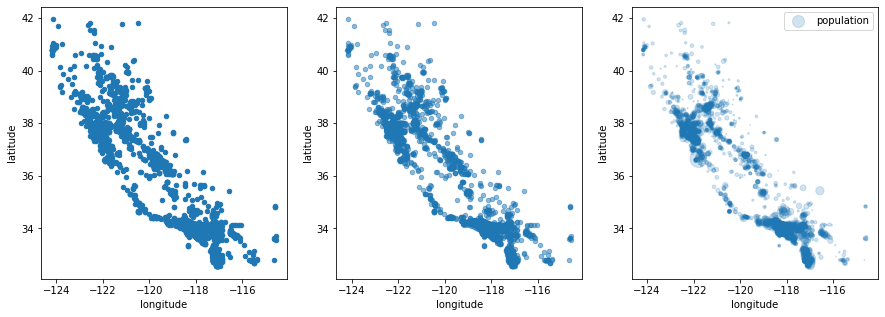

In [14]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
strat_test_set.plot(kind='scatter', x='longitude', y='latitude', ax=ax[0])
strat_test_set.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5, ax=ax[1])
strat_test_set.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2, s=strat_test_set['population']/100, 
                    label='population', ax=ax[2])

Text(0.5, 1.0, 'Median House Value')

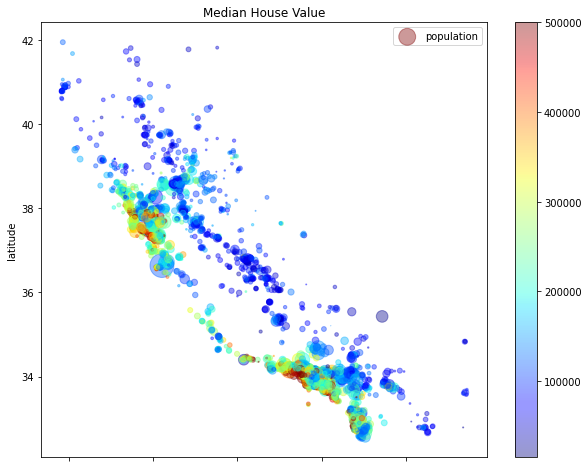

In [15]:
strat_test_set.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
                    s=strat_test_set['population']/50, label='population', figsize=(10,8), 
                    c=strat_test_set['median_house_value'], cmap=plt.get_cmap('jet'))
plt.title('Median House Value')

In [16]:
# for a small enough data_set we can use the standard correlation coefficient aka Pearson's r correlation
# where 1 means strong positive, and -1 means strong inverse correlation
#
corr_matrix = strat_test_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)
FS1 = corr_matrix['median_house_value'].sort_values(ascending=False).copy()
display(FS1)

median_house_value    1.000000
median_income         0.691867
income_cat            0.650579
total_rooms           0.131296
id                    0.096145
housing_median_age    0.071210
households            0.070947
total_bedrooms        0.057247
population           -0.016164
longitude            -0.039848
latitude             -0.150336
ocean_proximity      -0.198193
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='ocean_proximity', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>,
        <AxesSubplot:xlabel='ocean_proximity', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_ag

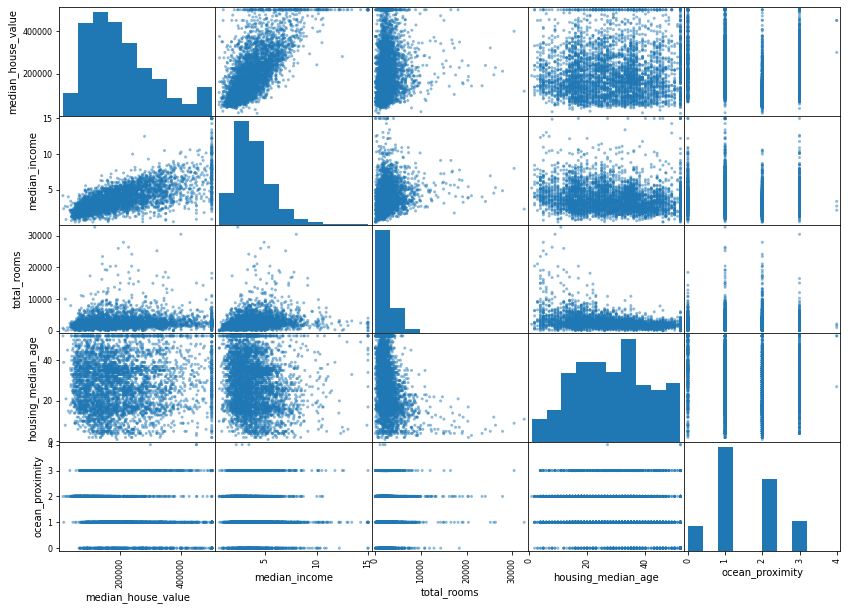

In [17]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age', 'ocean_proximity']
scatter_matrix(strat_test_set[attributes], figsize=(14,10))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

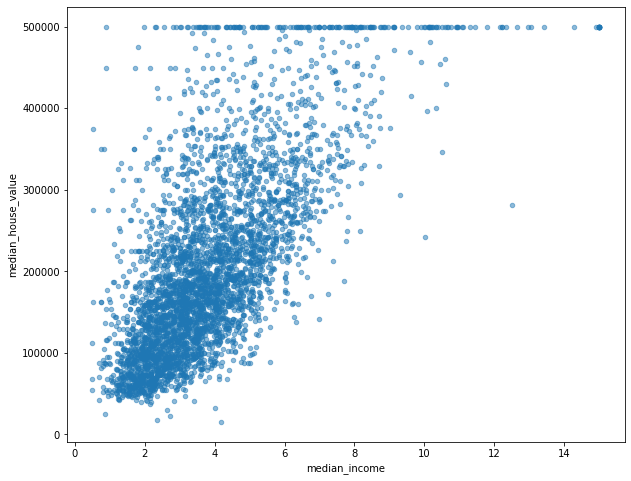

In [18]:
# Take a closer look at median_income vs median_house_value
#
strat_test_set.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.5, figsize=(10,8))
#
# Note: A line at 500000, clusters at 450000, and 350000 in median_house_value

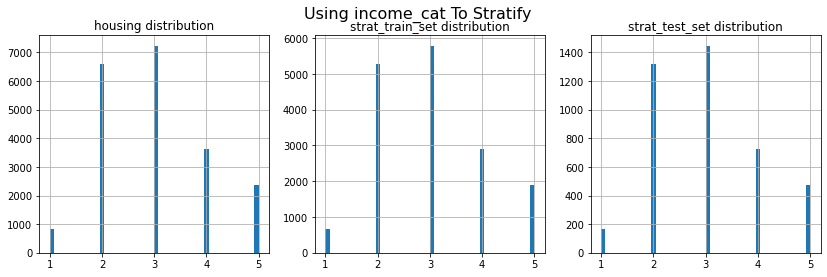

,%in_cat full,train,test
3.0,35.058140,35.059351,35.053295
2.0,31.884690,31.885901,31.879845
4.0,17.630814,17.629603,17.635659
5.0,11.443798,11.446221,11.434109
1.0,3.982558,3.978924,3.997093


In [19]:
# Start of Feature Engineering
#
# The total number of rooms in a district is not very useful if you don’t know how many households there are. 
# What we really want is the number of rooms per household. 
# The total number of bedrooms by itself is not very useful: we probably want to compare it to the number of rooms.
# And the population per household also seems like an interesting attribute combination to look at. 

housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

# In some cases there are hundres of rooms: wondering if there's a relationship?
housing['income_to_rooms'] = housing['median_income'] / housing['total_rooms']
housing['income_to_bedrooms'] = housing['median_income'] / housing['total_bedrooms']
housing['income_to_house_value'] = housing['median_income'] / housing['median_house_value']

# There is also a noticable break-down of a trend between 'total_rooms' and 'housing_median_age'
# fewer total_rooms in older houses, and far more scatter in younger/newer homes
# ** Continuous studies on scatter/dispursion in features will tell you if a feature is becoming OUT-DATED!!!
# very useful to supervised learning, where AI can be taught to spot feature retirement in unsupervised learning!!!

# The re-split the stratified train and test sets
for train_index, test_index in strat_split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# If we were to automate a process checking %deviation of key metric distribution [full, train, test] data...
s1 = housing['income_cat'].value_counts()/len(housing)*100
s2 = strat_train_set['income_cat'].value_counts()/len(strat_train_set)*100
s3 = strat_test_set['income_cat'].value_counts()/len(strat_test_set)*100
df1 = pd.concat([s1, s2, s3], axis=1)
df1.columns = ['%in_cat full', 'train', 'test']
    
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Using income_cat To Stratify', fontsize=16)
housing['income_cat'].hist(bins=50, ax=ax[0]).set_title('housing distribution')
strat_train_set['income_cat'].hist(bins=50, ax=ax[1]).set_title('strat_train_set distribution')
strat_test_set['income_cat'].hist(bins=50, ax=ax[2]).set_title('strat_test_set distribution')

plt.show()
display(df1)

In [20]:
# Re-inspect the dataframe
# we realize we still need a bunch of "Data clean-up & fix-up" before we focus on "Feature Engineering"
#
display(housing.info())
print('NOTE: Missing data on bedrooms propagates a need for special handling on both total_bedrooms & bedrooms_per_room')

corr_matrix = housing.corr()
display(corr_matrix)
FS2 = corr_matrix['median_house_value'].sort_values(ascending=False).copy()
display(FS2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20433 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   ocean_proximity           20640 non-null  int64  
 10  id                        20640 non-null  float64
 11  income_cat                20640 non-null  float64
 12  rooms_per_household       20640 non-null  float64
 13  bedrooms_per_room         20433 non-null  float64
 14  popula

None

NOTE: Missing data on bedrooms propagates a need for special handling on both total_bedrooms & bedrooms_per_room


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,income_to_rooms,income_to_bedrooms,income_to_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967,0.180381,-0.061647,-0.010690,-0.027540,0.092657,0.002476,-0.012792,-0.018937,0.011541
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160,-0.067586,0.026985,-0.085528,0.106389,-0.113815,0.002366,0.006998,0.011054,0.170047
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623,-0.204882,-0.183518,-0.146920,-0.153277,0.136089,0.013191,0.025546,0.022698,-0.224386
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153,0.014818,0.064198,0.220528,0.133798,-0.187900,-0.024581,-0.094397,-0.071850,0.009170
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686,0.004081,0.035934,0.015662,0.001538,0.084238,-0.028355,-0.103839,-0.084192,-0.085600
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650,-0.008511,0.030876,0.025809,-0.072213,0.035319,0.069863,-0.086592,-0.071584,-0.009073
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843,-0.016911,0.034020,0.038490,-0.080598,0.065087,-0.027309,-0.104673,-0.084300,-0.089000
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075,-0.129135,0.075203,0.902750,0.326895,-0.615661,0.018766,0.103350,0.130665,0.090281
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000,-0.210600,0.078035,0.643892,0.151948,-0.255880,-0.023737,0.041348,0.057641,-0.518606
ocean_proximity,0.180381,-0.067586,-0.204882,0.014818,0.004081,-0.008511,-0.016911,-0.129135,-0.210600,1.000000,0.297244,-0.134034,0.066124,-0.030635,0.010449,-0.009601,-0.014282,0.203491


median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
id                          0.078035
households                  0.065843
income_to_bedrooms          0.057641
total_bedrooms              0.049686
income_to_rooms             0.041348
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
ocean_proximity            -0.210600
bedrooms_per_room          -0.255880
income_to_house_value      -0.518606
Name: median_house_value, dtype: float64

In [21]:
display(FS1)
display(FS2)

median_house_value    1.000000
median_income         0.691867
income_cat            0.650579
total_rooms           0.131296
id                    0.096145
housing_median_age    0.071210
households            0.070947
total_bedrooms        0.057247
population           -0.016164
longitude            -0.039848
latitude             -0.150336
ocean_proximity      -0.198193
Name: median_house_value, dtype: float64

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
id                          0.078035
households                  0.065843
income_to_bedrooms          0.057641
total_bedrooms              0.049686
income_to_rooms             0.041348
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
ocean_proximity            -0.210600
bedrooms_per_room          -0.255880
income_to_house_value      -0.518606
Name: median_house_value, dtype: float64

In [22]:
strat_train_labels = strat_train_set['median_house_value'].copy()
strat_train_set.drop(['median_house_value'], axis=1, inplace=True)
display(strat_train_set.head())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,id,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,income_to_rooms,income_to_bedrooms,income_to_house_value
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,2,7976.3608,2.0,5.485836,0.205784,3.168555,0.000561,0.002727,0.000030
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,3,11622.8593,5.0,6.927083,0.160714,2.623698,0.001191,0.007412,0.000023
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,2,-1302.4448,2.0,5.393333,0.191595,2.223333,0.001777,0.009274,0.000035
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,3,10216.9925,2.0,3.886128,0.276505,1.859213,0.001186,0.004290,0.000020
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,1,16426.9640,3.0,6.096552,0.182692,3.167241,0.001272,0.006960,0.000019


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,id,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,income_to_rooms,income_to_bedrooms,income_to_house_value
count,158.000000,158.000000,158.000000,158.000000,0.0,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,0.0,158.000000,158.000000,0.0,158.000000
mean,-119.613354,35.662658,29.848101,2465.626582,NaN,1485.202532,503.386076,3.734027,1.481013,6132.676379,2.917722,5.109477,NaN,3.028341,0.002566,NaN,0.000021
std,2.021178,2.124542,11.880068,1740.043354,NaN,1099.061619,400.579703,1.950319,0.864896,6177.631766,1.034224,1.271076,NaN,0.749038,0.005318,NaN,0.000009
min,-124.130000,32.660000,5.000000,154.000000,NaN,37.000000,16.000000,0.852700,0.000000,-4323.983200,1.000000,2.096692,NaN,1.317891,0.000163,NaN,0.000005
25%,-121.880000,34.022500,21.250000,1303.250000,NaN,798.750000,257.500000,2.563325,1.000000,741.859175,2.000000,4.260939,NaN,2.482256,0.001032,NaN,0.000014
50%,-118.655000,34.285000,31.000000,2048.000000,NaN,1168.000000,424.500000,3.310350,1.000000,5194.893600,3.000000,5.072419,NaN,2.881034,0.001600,NaN,0.000020
75%,-118.105000,37.667500,38.000000,3183.500000,NaN,1887.500000,622.750000,4.372925,2.000000,11496.110250,3.000000,5.884714,NaN,3.404174,0.002542,NaN,0.000026
max,-114.590000,40.920000,52.000000,11709.000000,NaN,7604.000000,3589.000000,15.000100,3.000000,16414.278400,5.000000,9.625000,NaN,6.039474,0.065106,NaN,0.000055


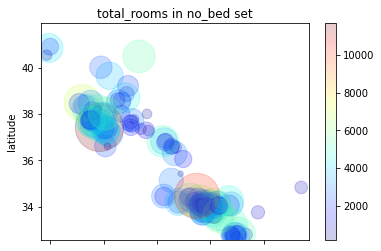

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,id,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,income_to_rooms,income_to_bedrooms,income_to_house_value
count,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,16354.000000,1.635400e+04
mean,-119.575271,35.639089,28.641861,2624.055766,534.914639,1419.054421,496.950226,3.877255,1.464290,6065.259378,3.007643,5.443603,0.212873,3.097127,0.002757,0.014412,2.138625e-05
std,2.001699,2.138155,12.581134,2141.891885,412.665649,1115.836568,375.460231,1.904496,0.854613,5957.330783,1.054790,2.621122,0.057378,11.640422,0.010135,0.060341,9.020467e-06
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,0.000000,-4630.072400,1.000000,1.130435,0.100000,0.692308,0.000102,0.000349,9.997980e-07
25%,-121.800000,33.940000,18.000000,1445.000000,295.000000,784.000000,279.000000,2.567075,1.000000,1142.922025,2.000000,4.443630,0.175304,2.431064,0.001046,0.004678,1.518564e-05
50%,-118.510000,34.260000,29.000000,2120.000000,433.000000,1164.000000,408.000000,3.544250,1.000000,6390.779350,3.000000,5.234189,0.203027,2.817098,0.001630,0.007955,2.024026e-05
75%,-118.010000,37.720000,37.000000,3138.500000,644.000000,1715.750000,602.000000,4.747425,2.000000,11325.801300,4.000000,6.057667,0.239816,3.279982,0.002560,0.013480,2.599260e-05
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,4.000000,16434.748300,5.000000,141.909091,1.000000,1243.333333,0.538232,3.750025,1.400093e-04


In [23]:
# Clean-up time... look at what records have total_bedrooms NaN
no_beds = strat_train_set.loc[strat_train_set['total_bedrooms'].isna()]
display(no_beds.describe())
no_beds.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2, s=no_beds['total_rooms']/5,
                    c=no_beds['total_rooms'], cmap=plt.get_cmap('jet'), colorbar=True,
                    xlim=(housing['longitude'].min(), housing['longitude'].max()),
                    ylim=(housing['latitude'].min(), housing['latitude'].max()),
            ).set_title('total_rooms in no_bed set')
plt.show()
strat_train_set.dropna(subset=['total_bedrooms']).describe()

In [24]:
# Data Engineering (clean-up and fixes should be done before exploring Feature Engineering)
#
# Use ML to fix missing 'total_bedrooms' data
#

# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer as Imputer

imputer = Imputer(strategy='median')

train_set_num = strat_train_set.drop('ocean_proximity', axis=1)

imputer.fit(train_set_num)
# print(imputer.statistics_)
X = imputer.transform(train_set_num)

train_num_chk = pd.DataFrame(X, columns=train_set_num.columns)
# But need to recompute features that had anything to do with total_bedrooms with the inferred values
train_num_chk['bedrooms_per_room'] = train_num_chk['total_bedrooms'] / train_num_chk['total_rooms']
train_num_chk['income_to_bedrooms'] = train_num_chk['median_income'] / train_num_chk['total_bedrooms']

l = no_beds['id'].tolist()
print('rows imputer estimated total_bedrooms:', len(l))
display(train_num_chk.loc[train_num_chk['id'].isin(l)])

X = train_num_chk.values
print('Double check the shape of X:', X.shape)

rows imputer estimated total_bedrooms: 158


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,id,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,income_to_rooms,income_to_bedrooms,income_to_house_value
86,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,-3018.3904,2.0,4.707668,0.146929,1.317891,0.000995,0.006774,0.000035
373,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,6939.2449,3.0,4.537074,0.191254,3.947896,0.001510,0.007897,0.000019
431,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,14444.4550,3.0,5.826196,0.187203,2.403023,0.001635,0.008733,0.000026
528,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,150.8101,3.0,4.448980,0.331040,2.840136,0.003279,0.009906,0.000020
647,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,12285.2080,5.0,6.835417,0.131972,2.385417,0.001938,0.014684,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15894,-121.95,38.03,5.0,5526.0,433.0,3207.0,1012.0,4.0767,-3287.7585,3.0,5.460474,0.078357,3.168972,0.000738,0.009415,0.000028
16109,-118.37,34.07,50.0,2519.0,433.0,1117.0,516.0,4.3667,658.1341,3.0,4.881783,0.171894,2.164729,0.001734,0.010085,0.000011
16129,-118.50,34.46,17.0,10267.0,433.0,4956.0,1483.0,5.5061,5065.4900,4.0,6.923129,0.042174,3.341875,0.000536,0.012716,0.000023
16152,-122.48,37.70,33.0,4492.0,433.0,3477.0,1537.0,3.0546,12139.5040,3.0,2.922576,0.096394,2.262199,0.000680,0.007055,0.000010


Double check the shape of X: (16512, 16)
